# Invert Yellowstone Data

In [3]:
from SimPEG import (
    maps, utils, data, optimization, maps, regularization, 
    inverse_problem, directives, inversion, data_misfit
)
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import natural_source as nsem
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from matplotlib.colors import LogNorm
from ipywidgets import interact, widgets
import warnings
from mtpy import MTCollection
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\mtidp22-019\.conda\envs\em\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: -PKG-VERSION is an invalid version and will not be supported in a future release
  warnings.warn(
2022-10-20 15:29:38,554 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\mtidp22-019\.conda\envs\em\lib\site-packages\mth5-0.3.0-py3.10.egg\logs\mth5_debug.log


## Get Data from MTpy

In [5]:
mc = MTCollection()
mc.open_collection("../../data/transfer_functions/yellowstone_mt_collection.h5")

In [6]:
mc.apply_bbox(*[-111.4, -109.85, 44, 45.2])

In [7]:
%%time
mt_data = mc.to_mt_data()

CPU times: total: 22.4 s
Wall time: 22.4 s


In [8]:
for station_id in ["YNP44S", "YNP33B", "WYYS3"]:
    mt_data.remove_station(station_id)

In [9]:
interp_periods = np.logspace(-2, 3, 5)
interp_mt_data = mt_data.interpolate(interp_periods, inplace=False)

In [10]:
interp_mt_data.compute_model_errors()
interp_mt_data.model_epsg = 32612
interp_mt_data.calculate_rel_locations()

In [34]:
sdf = interp_mt_data.to_dataframe()

In [12]:
gdf = interp_mt_data.to_geo_df()

In [13]:
rx_loc = np.hstack(
    (mkvc(gdf.model_north.to_numpy(), 2), 
     mkvc(gdf.model_east.to_numpy(), 2),
     np.zeros((np.prod(gdf.shape[0]), 1)))
)

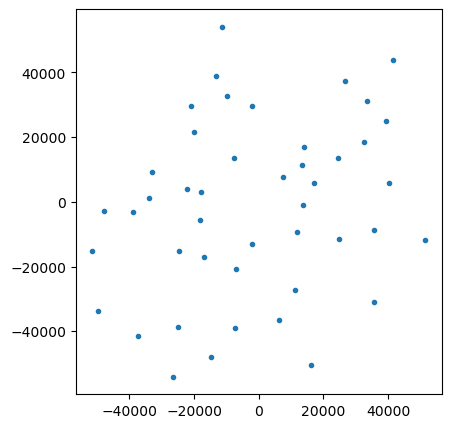

In [14]:
#frequencies = np.array([1e-1, 2])
#station_spacing = 8000
#factor_spacing = 4
#rx_x, rx_y = np.meshgrid(np.arange(0, 50000, station_spacing), np.arange(0, 50000, station_spacing))
#rx_loc = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1))))
#print(rx_loc.shape)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
ax.set_aspect(1)

In [15]:
import discretize.utils as dis_utils
from discretize import TreeMesh
from geoana.em.fdem import skin_depth

def get_octree_mesh(
    rx_loc, frequencies, sigma_background, station_spacing,
    factor_x_pad=2,
    factor_y_pad=2,
    factor_z_pad_down=2,
    factor_z_core=1,
    factor_z_pad_up=1,
    factor_spacing=4,
    ):
    f_min =  frequencies.min()
    f_max =  frequencies.max()
    
    lx_pad = skin_depth(f_min, sigma_background) * factor_x_pad
    ly_pad = skin_depth(f_min, sigma_background) * factor_y_pad
    lz_pad_down = skin_depth(f_min, sigma_background) * factor_z_pad_down
    lz_core = skin_depth(f_min, sigma_background) * factor_z_core
    lz_pad_up = skin_depth(f_min, sigma_background) * factor_z_pad_up

    lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
    ly_core = rx_loc[:,1].max() - rx_loc[:,1].min()
    lx = lx_pad + lx_core + lx_pad
    ly = ly_pad + ly_core + ly_pad
    lz = lz_pad_down + lz_core + lz_pad_up
    dx = station_spacing / factor_spacing
    dy = station_spacing / factor_spacing
    dz = np.round(skin_depth(f_max, sigma_background) /4, decimals=-1)

    # Compute number of base mesh cells required in x and y
    nbcx = 2 ** int(np.ceil(np.log(lx / dx) / np.log(2.0)))
    nbcy = 2 ** int(np.ceil(np.log(ly / dy) / np.log(2.0)))
    nbcz = 2 ** int(np.ceil(np.log(lz / dz) / np.log(2.0)))
    
    mesh = dis_utils.mesh_builder_xyz(
        rx_loc, 
        [dx, dy, dz],
        padding_distance=[[lx_pad, lx_pad], [ly_pad, ly_pad], [lz_pad_down, lz_pad_up]],
        depth_core=lz_core,
        mesh_type='tree'
    )
    X, Y = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
    topo = np.c_[X.flatten(), Y.flatten(), np.zeros(X.size)]
    mesh = refine_tree_xyz(
        mesh, topo, octree_levels=[0, 0, 4], method="surface", finalize=False
    )

    mesh = refine_tree_xyz(
        mesh, rx_loc, octree_levels=[1, 2, 1], method="radial", finalize=True
    )    
    return mesh

In [16]:
mesh = get_octree_mesh(
    rx_loc,
    1./interp_periods,
    1e-2, 
    3500,
    factor_spacing=2,
    factor_x_pad=4,
    factor_y_pad=4
)
print(mesh.n_cells)

390223


In [17]:
sigma_background = np.ones(mesh.nC) * 1e-8
ind_active = mesh.cell_centers[:,2] < 0.
sigma_background[ind_active] = 1e-2

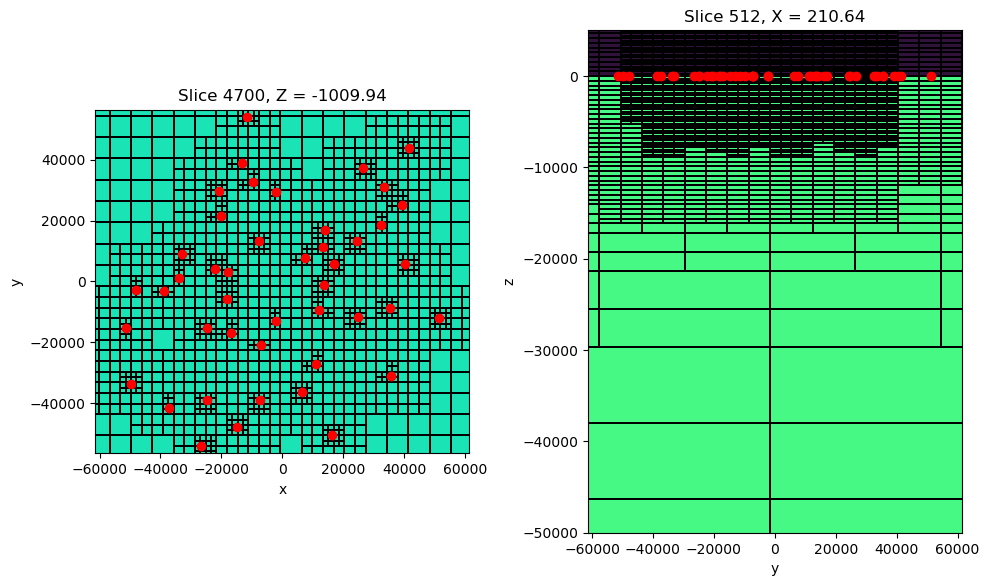

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,2,1)
mesh.plot_slice(
    sigma_background, grid=True, normal='Z', ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=-1000.
)
ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')
ax.set_aspect(1)

ax2 = fig.add_subplot(1,2,2, sharex=ax)
mesh.plot_slice(
    sigma_background, grid=True, normal='X', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-4, vmax=10)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min()-10000, rx_loc[:,0].max()+10000), 
    range_y=(-50000, 50000*0.1)
)
ax2.plot(rx_loc[:,0], rx_loc[:,2], 'ro')
ax2.set_aspect(3)
fig.tight_layout()

In [19]:
# Generate a Survey
rx_list = []
rx_orientations_impedance = ['xy', 'yx', 'xx', 'yy']
for rx_orientation in rx_orientations_impedance:    
    rx_list.append(     
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
rx_orientations_tipper = ['zx', 'zy']
for rx_orientation in rx_orientations_tipper:    
    rx_list.append(     
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
# Source list
src_list = [nsem.sources.Planewave_xy_1Dprimary(rx_list, frequency=f) for f in 1./interp_periods]

# Survey MT
survey = nsem.Survey(src_list)

In [20]:
rx_orientations = rx_orientations_impedance + rx_orientations_tipper

```
# forward model to get the model response for the synthetic data

# Set the mapping
active_map = maps.InjectActiveCells(
    mesh=mesh, indActive=ind_active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * active_map

# True model 
m_true = np.log(sigma_background[ind_active])

# Setup the problem object
simulation = nsem.simulation.Simulation3DPrimarySecondary( 
    mesh,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=sigma_background,
    solver=Solver
)
dpred = simulation.dpred(m_true)
```

In [51]:
frequencies = 1/interp_periods
components = ["zxx", "zxy", "zyx", "zyy", "tzx", "tzy"]
n_rx = rx_loc.shape[0]
n_freq = len(interp_periods)
n_component = 2
n_orientation = len(rx_orientations)

f_dict = dict([(round(ff, 5), ii) for ii, ff in enumerate(1/interp_periods)])
observations = np.zeros((n_freq, n_orientation, n_component, n_rx))
errors = np.zeros_like(observations)
for s_index, station in enumerate(gdf.station):
    station_df = sdf.loc[sdf.station == station]
    station_df.set_index("period", inplace=True)
    for row in station_df.itertuples():
        f_index = f_dict[round(1./row.Index, 5)]
        for c_index, comp in enumerate(components):
            value = getattr(row, comp)
            err = getattr(row, f"{comp}_error")
            observations[f_index, c_index, 0, s_index] = value.real
            observations[f_index, c_index, 1, s_index] = value.imag
            errors[f_index, c_index, 0, s_index] = err
            errors[f_index, c_index, 1, s_index] = err
        

In [52]:
observations[np.where(observations == 0)] = 100
errors[np.where(errors == 0)] = np.inf

In [53]:
observations.shape

(5, 6, 2, 45)

```
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
DCLEAN = DOBS.copy()
FLOOR = np.zeros_like(DOBS)
FLOOR[:,2,0,:] = np.percentile(abs(DOBS[:,2,0,:].flatten()), 90) * 0.1
FLOOR[:,2,1,:] = np.percentile(abs(DOBS[:,2,1,:].flatten()), 90) * 0.1
FLOOR[:,3,0,:] = np.percentile(abs(DOBS[:,3,0,:].flatten()), 90) * 0.1
FLOOR[:,3,1,:] = np.percentile(abs(DOBS[:,3,1,:].flatten()), 90) * 0.1
FLOOR[:,4,0,:] = np.percentile(abs(DOBS[:,4,0,:].flatten()), 90) * 0.1
FLOOR[:,4,1,:] = np.percentile(abs(DOBS[:,4,1,:].flatten()), 90) * 0.1
FLOOR[:,5,0,:] = np.percentile(abs(DOBS[:,5,0,:].flatten()), 90) * 0.1
FLOOR[:,5,1,:] = np.percentile(abs(DOBS[:,5,1,:].flatten()), 90) * 0.1
STD = abs(DOBS) * relative_error + FLOOR
# STD = (FLOOR)
standard_deviation = STD.flatten()
dobs = DOBS.flatten() 
dobs += abs(dobs) * relative_error * np.random.randn(dobs.size)
DOBS = dobs.reshape((n_freq, n_orientation, n_component, n_rx))
# + standard_deviation * np.random.randn(standard_deviation.size)
```

In [54]:
def foo_data(i_freq, i_orientation, i_component):
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    vmin = np.min([observations[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([observations[i_freq, i_orientation, i_component,:].max()])
    out1 = utils.plot2Ddata(rx_loc, observations[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax, contourOpts={'cmap':'turbo'}, ncontour=20)
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    if i_orientation<4:
        transfer_type = "Z"
    else:
        transfer_type = "T"
    ax.set_title(f"Frequency={:.1e}, {:s}{:s}-{:s}".format(1./interp_periods[i_freq], transfer_type, rx_orientations[i_orientation], components[i_component]))

In [59]:
interact(
    foo_data,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_component-1), 
    i_component=widgets.IntSlider(min=0, max=n_orientation-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=4), IntSlider(value=0, description='i_orien…

<function __main__.foo_data(i_freq, i_orientation, i_component)>

In [57]:
# Assign uncertainties
# make data object
data_object = data.Data(survey, dobs=observations.flatten(), standard_deviation=errors.flatten())

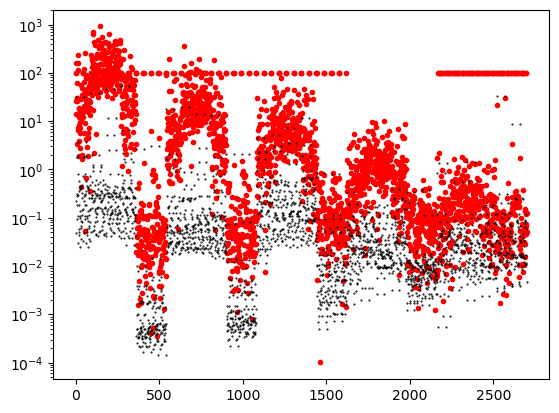

In [58]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy((data_object.standard_deviation), 'k.', ms=1)
plt.show()

In [64]:
sigma_background

array([1.e-02, 1.e-02, 1.e-02, ..., 1.e-08, 1.e-08, 1.e-08])

In [ ]:
sigma = mapping * m_true

In [ ]:
# Set the mapping
active_map = maps.InjectActiveCells(
    mesh=mesh, indActive=ind_active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * active_map

# True model 
m_true = np.log(sigma_background[ind_active])

# Setup the problem object
simulation = nsem.simulation.Simulation3DPrimarySecondary(
    
    mesh,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=sigma_background,
    solver=Solver

)
dpred = simulation.dpred(m_true)

In [60]:
%%time

# Optimization
opt = optimization.ProjectedGNCG(maxIter=10, maxIterCG=20, upper=np.inf, lower=-np.inf)
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)
# Regularization
dz = mesh.hz.min()
dx = mesh.hx.min()
regmap = maps.IdentityMap(nP=int(ind_active.sum()))
reg = regularization.Sparse(mesh, indActive=ind_active, mapping=regmap)
reg.alpha_s = 1e-5
reg.alpha_x = dz/dx
reg.alpha_y = dz/dx
reg.alpha_z = 1.

# Inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta = directives.BetaSchedule(coolingRate=1, coolingFactor=2)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
target = directives.TargetMisfit()
# Create an inversion object
save_dictionary = directives.SaveOutputDictEveryIteration()
directive_list = [beta, beta_est, target, save_dictionary]
inv = inversion.BaseInversion(inv_prob, directiveList=directive_list)

# Set an intitial guess
m_0 = np.log(sigma_background[ind_active])


CPU times: total: 31.2 ms
Wall time: 31.9 ms


In [43]:
target.target

588.0

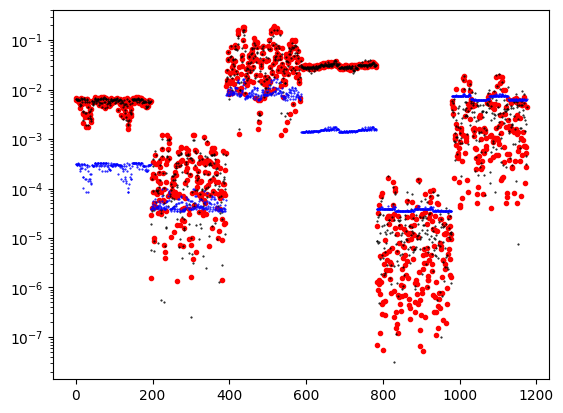

In [44]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(inv_prob.dpred), 'k.', ms=1)
plt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)
plt.show()

In [45]:
iteration = len(save_dictionary.outDict)
m = save_dictionary.outDict[iteration]['m']
sigma_est = mapping*m
pred = save_dictionary.outDict[iteration]['dpred']
DPRED = pred.reshape((n_freq, n_orientation, n_component, n_rx))
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
MISFIT = (DPRED-DOBS)/STD

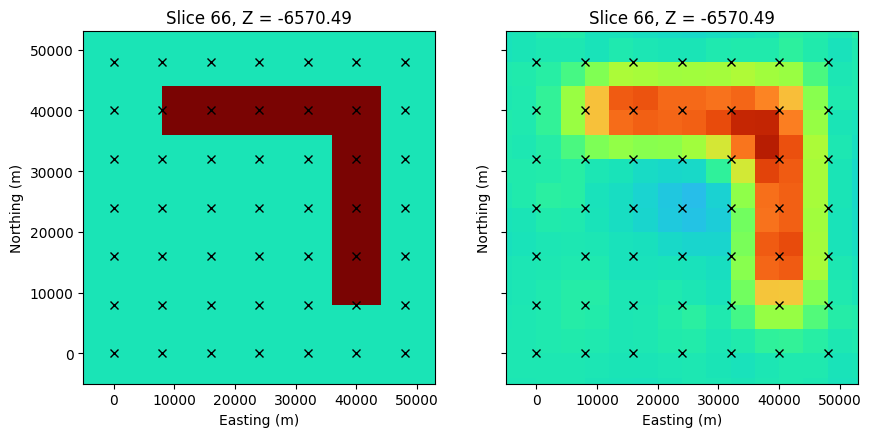

In [46]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
z_loc = -7000.
y_loc = 10000.
mesh.plot_slice(
    sigma, grid=False, normal='Z', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
mesh.plot_slice(
    sigma_est, grid=False, normal='Z', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

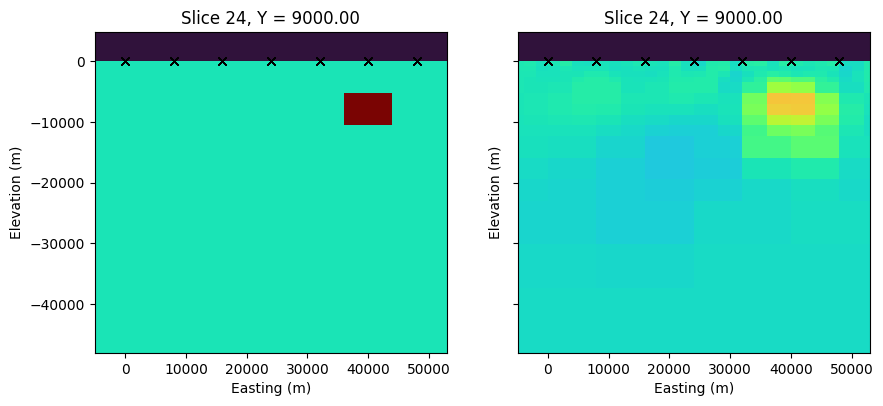

In [48]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
mesh.plot_slice(
    sigma, grid=False, normal='Y', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(-lx_core, lx_core*0.1),
    slice_loc=y_loc
)
mesh.plot_slice(
    sigma_est, grid=False, normal='Y', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(-lx_core, lx_core*0.1),
    slice_loc=y_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,2], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")


In [49]:
from ipywidgets import interact, widgets

In [50]:
def foo_misfit(i_freq, i_orientation, i_component):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    ax1, ax2, ax3 = axs

    vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DPRED[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DPRED[i_freq, i_orientation, i_component,:].max()])

    out1 = utils.plot2Ddata(rx_loc, DOBS[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax1, contourOpts={'cmap':'turbo'}, ncontour=20)
    out2 = utils.plot2Ddata(rx_loc, DPRED[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax2, contourOpts={'cmap':'turbo'}, ncontour=20)
    out3 = utils.plot2Ddata(rx_loc, MISFIT[i_freq, i_orientation, i_component,:], clim=(-5, 5), ax=ax3, contourOpts={'cmap':'turbo'}, ncontour=20)

    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')

In [51]:
interact(
    foo_misfit,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=1), IntSlider(value=0, description='i_orien…

<function __main__.foo_misfit(i_freq, i_orientation, i_component)>

In [52]:
models = {}
models["estimated_sigma"] = sigma_est
models['true_sigma'] = sigma
mesh.write_vtk("mt_synthetic",models=models)